# Анализ оценок вина на сайте WineEnthusiast

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv')

In [3]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine.drop(columns='Unnamed: 0', inplace=True)

In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


## Описание набора данных

Набор содержит данные об оценках вина на сайте [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine). Данные собирались в течение недели с 22 ноября 2017 г. Файл с данными взят с [Kaggle](https://www.kaggle.com/zynicide/wine-reviews)

Файл содержит 13 колонок с данными в следующем порядке: 
* страна производства вина
* описание
* обозначение
* оценка (от 80 до 100)
* цена (\\$)
* штат/область производства
* регион(1 строка)
* регион(2 строка)
* имя дегустатора
* твиттер дегустатора
* название вина
* сорт вина
* винодельня

## Что проверяем и что хотим получить

**По результатам анализа я хочу узнать:**
* В каких местах производят лучшие вина
* Где лучше производят популярные сорта
* Есть ли связь между оценкой вина и его стоимостью

### В каких местах производят лучшие вина

В производстве вин одни страны сильно опережают другие. Если сравнивать все страны между собой, это может привести к ошибкам: 
1. Вино с всего несколькими хорошими отзывами может опередить на несколько баллов распространенное вино, которое, возможно, не уступает первому, но получило среднюю оценку ниже из-за большего разброса.
2. Какая-то страна может производить всего несколько хороших сортов, и будет иметь среднюю оценку выше, чем страна с большим ассортиментом, т.к. у последней часть ассортимента будет тянуть оценку вниз.

Поэтому, проводить сравнение буду предварительно разделив страны на несколько групп по объему производства. Информации об объемах производства вина у меня нет, но, думаю, количество отзывов примерно отражает этот показатель. Ниже привидено количество отзывов по каждой стране

In [6]:
wine['country'].value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Czech Re

<AxesSubplot:title={'center':'Топ 10 стран по производству вина'}, ylabel='Количество отзывов'>

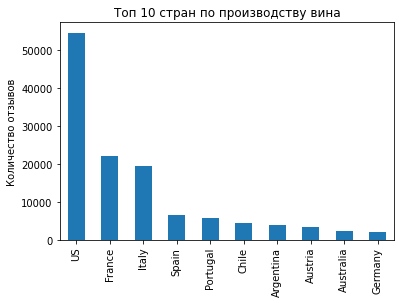

In [7]:
wine['country'].value_counts().head(10).plot.bar(title='Топ 10 стран по производству вина', ylabel='Количество отзывов')

Разделю страны на следующие группы:
* Более 10 тыс. отзывов (США, Франция, Италия)
* От 1000 до 10 тыс. отзывов (Испания, Португалия, Чили, Аргентина, Австрия, Австралия, Германия, Новая Зеландия, ЮАР)
* Менее 1000 отзывов

In [8]:
top_countries = wine['country'].value_counts()[wine['country'].value_counts() > 10000]
middle_countries = wine['country'].value_counts()[wine['country'].value_counts().between(1000,10000)]
underdog_countries = wine['country'].value_counts()[wine['country'].value_counts() < 1000]

Ниже приведены топ 10 областей для каждой категории. Области упорядочены по убыванию средней оценки вин

In [9]:
top_regions = wine[wine['country'].isin(top_countries.index)].groupby(['country','province'], as_index=False)['points'].mean().sort_values('points', ascending=False)[:10]
print(top_regions)
print(f'\nСредняя оценка: {top_regions.points.mean()}')

   country      province     points
4   France     Champagne  90.234966
42      US  Rhode Island  90.000000
3   France      Burgundy  89.569347
16   Italy      Piedmont  89.536873
0   France        Alsace  89.372131
19   Italy       Tuscany  89.074614
40      US        Oregon  89.051926
9   France  Rhône Valley  89.007401
46      US    Washington  88.947216
13   Italy      Lombardy  88.874296

Средняя оценка: 89.36687705516601


In [10]:
middle_regions = wine[wine['country'].isin(middle_countries.index)].groupby(['country','province'],  as_index=False)['points'].mean().sort_values('points', ascending=False)[:10]
print(middle_regions)
print(f'\nСредняя оценка: {middle_regions.points.mean()}')

      country       province     points
19    Austria  Südburgenland  94.000000
124  Portugal        Madeira  93.230769
81    Germany    Mittelrhein  92.000000
68      Chile    Puente Alto  91.733333
25    Austria         Wachau  91.620397
75      Chile     Santa Cruz  91.500000
12    Austria        Kamptal  91.454768
23    Austria     Traisental  91.255814
11    Austria      Eisenberg  91.187500
14    Austria     Leithaberg  91.166667

Средняя оценка: 91.91492475109854


In [11]:
underdog_regions = wine[wine['country'].isin(underdog_countries.index)].groupby(['country','province'],  as_index=False)['points'].mean().sort_values('points', ascending=False)[:10]
print(underdog_regions)
print(f'\nСредняя оценка: {underdog_regions.points.mean()}')

         country         province     points
39       England          England  91.581081
88        Greece          Retsina  91.000000
102      Hungary           Tokaji  90.847826
104        India           Nashik  90.222222
162  Switzerland           Valais  90.000000
159  Switzerland        Neuchâtel  90.000000
20       Croatia           Dingač  90.000000
73        Greece       Markopoulo  90.000000
110       Israel       Haut-Judeé  89.750000
112       Israel  Jerusalem Hills  89.750000

Средняя оценка: 90.31511293902598


По всем лучшим областям средняя оценки варьируются от 88 до 94. Наивысшую среднюю оценку (94) имеет область Südburgenland в Австрии

Посмотрим, как распределены оценки в целом по всему набору

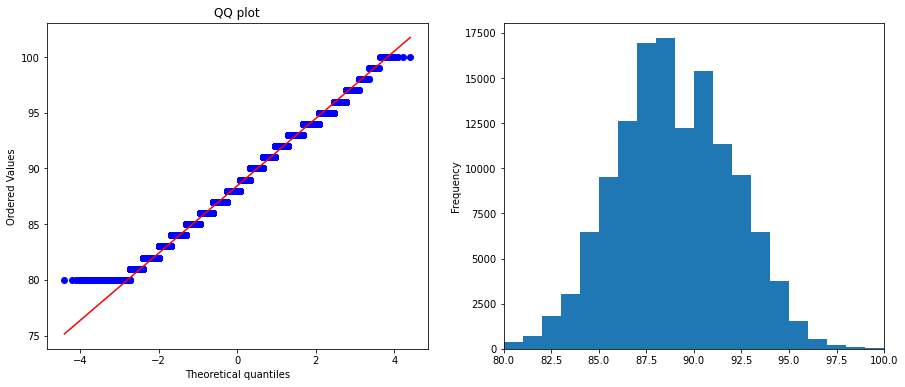

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

stats.probplot(wine['points'], dist='norm', plot=axes[0])
axes[0].set_title("QQ plot")

wine['points'].plot(ax=axes[1], kind='hist', xlim=(80,100), bins=20)

plt.show()

In [13]:
wine['points'].describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

Оценки распределены нормально с небольшими отклонениями. Оценки лучших мест относятся к 3-4 квантилю. Т.е. около половины оценок находятся в диапазоне оценок лучших регионов. Проверим, какую долю оценок составляют оценки, относящиеся к лучшим регионам.

In [14]:
all_top_regions = pd.concat([top_regions, middle_regions, underdog_regions])
all_top_regions.count()

country     30
province    30
points      30
dtype: int64

In [15]:
top_count = wine.loc[(wine['country'].isin(all_top_regions['country']))&(wine['province'].isin(all_top_regions['province'])), 'points'].count()
top_share = top_count/wine['points'].count()
top_share * 100

26.41666217848597

Половина всех оценок относится к 26% всех регионов. Полагаю, это связано с тем, что чем чем лучше вино, тем больше оно распространено, соответственно лучшие регионы по производству вин получают больше оценок

#### Вывод
Среди самых распространенных вин лучшие оценки имеют произведенные в:
* Франция - Champagne (родина игристого), Burgundy, Alsace, Rhône Valley
* Италия - Piedmont, Tuscany, Lombardy
* США - Rhode Island, Oregon, Washington

Среди менее популярных:
* Австрия - Südburgenland, Wachau, Kamptal, Traisental, Eisenberg, Leithaberg
* Португалия - Madeira
* Германия - Mittelrhein
* Чили - Puente Alto, Santa Cruz

Редко встречающиеся:
* Англия - England (видимо, нет разделения на области)
* Греция - Retsina, Markopoulo
* Венгрия - Tokaji
* Индия - Nashik
* Швейцария - Valais, Neuchâtel
* Хорватия - Dingač
* Израиль - Haut-Judeé, Jerusalem Hills


### Где лучше производят популярные сорта

Выделим 5 самых популярных сортов и сравним их средние оценки

In [16]:
top_var = wine['variety'].value_counts().head().index
wine[wine['variety'].isin(top_var)].groupby('variety')['points'].mean().sort_values(ascending=False)

variety
Pinot Noir                  89.411468
Bordeaux-style Red Blend    89.106435
Cabernet Sauvignon          88.607580
Red Blend                   88.380282
Chardonnay                  88.340083
Name: points, dtype: float64

Самые популярные сорта имеют среднюю оценку 88-90 баллов, что является медианой для всей выборки.

Ниже приведены средние оценки для каждого сорта в различных местах производства. При оценке учитывал только места, по которым по оцениваемому сорту есть 50+ отзывов.

Средняя оценка вин в различных местах производства


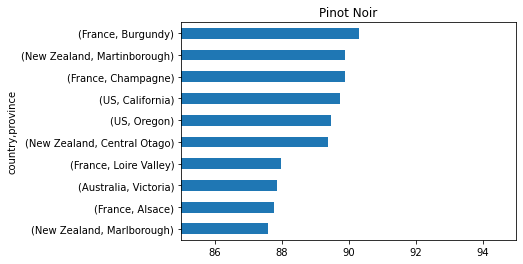

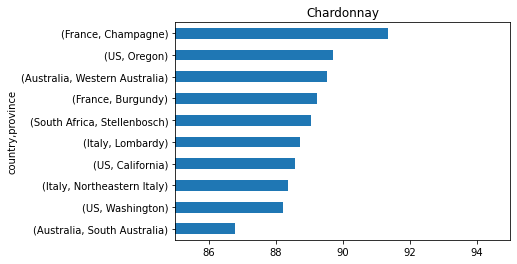

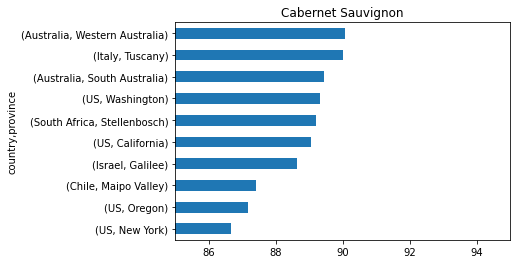

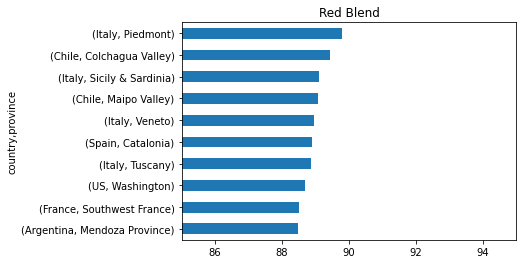

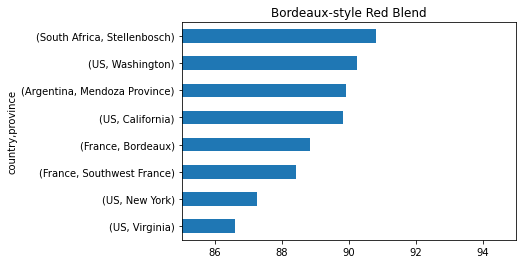

In [17]:
print('Средняя оценка вин в различных местах производства')
for var in top_var:
    filter_1 = wine['variety']==var
    filter_2 = wine[filter_1].groupby(['country', 'province'])['points'].transform('size') > 50
    wine[(filter_1)&(filter_2)].groupby(['country', 'province'])['points'].mean().sort_values(ascending=False)[:10].sort_values().plot.barh(xlim=(85,95), title=var)
    plt.show()

#### Вывод
Места производства популярных сортов вин с высокими оценками (сорт:место):
* Pinot Noir: France Burgundi
* Bordeaux-style Red Blend: South Africa Stellebosch
* Cabernet Sauvignon: Western Australia, Italy Tuscany
* Red Blend: Italy Piedmont
* Chardonnay: France Champagne

### Есть ли связь между оценкой вина и его стоимостью

In [18]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Посмотрим на самые дорогие и самые высокооцениваемые виды вина.

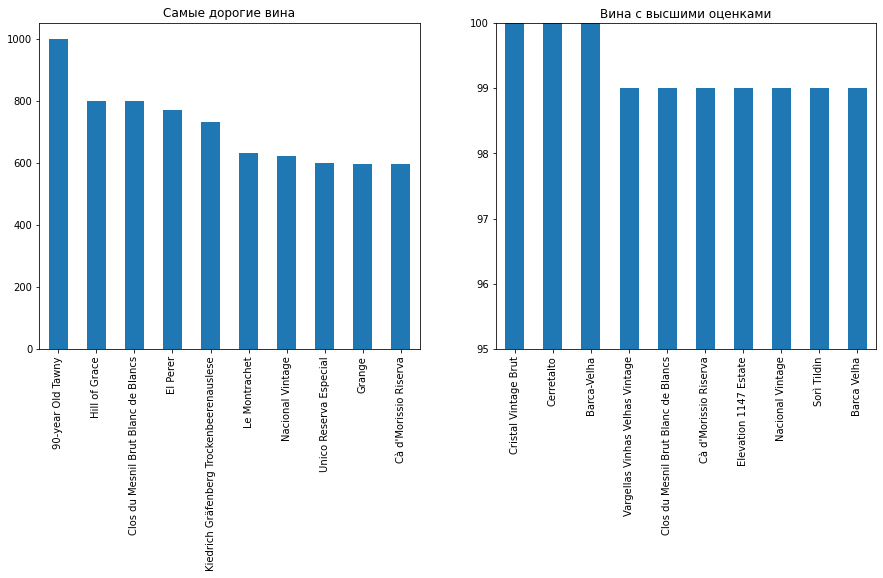

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
wine.groupby('designation')['price'].mean().sort_values(ascending=False).head(10).plot(kind='bar', ax=axes[0], xlabel='', title='Самые дорогие вина')
wine.groupby('designation')['points'].mean().sort_values(ascending=False).head(10).plot(kind='bar', ax=axes[1], ylim=(95,100), xlabel='', title='Вина с высшими оценками')
plt.show()

In [20]:
wine.groupby('designation')['price'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(10)

,mean,count
designation,,
90-year Old Tawny,1000.000000,1
Hill of Grace,800.000000,2
Clos du Mesnil Brut Blanc de Blancs,800.000000,1
El Perer,770.000000,1
Kiedrich Gräfenberg Trockenbeerenauslese,730.666667,6
Le Montrachet,630.000000,1
Nacional Vintage,622.500000,2
Unico Reserva Especial,600.000000,1
Grange,596.250000,4


In [21]:
wine.groupby('designation')['points'].agg(['mean', 'count']).sort_values(by='mean', ascending=False).head(10)

,mean,count
designation,,
Cristal Vintage Brut,100.0,1
Cerretalto,100.0,1
Barca-Velha,100.0,1
Vargellas Vinhas Velhas Vintage,99.0,1
Clos du Mesnil Brut Blanc de Blancs,99.0,1
Cà d'Morissio Riserva,99.0,1
Elevation 1147 Estate,99.0,1
Nacional Vintage,99.0,2
Sorì Tildìn,99.0,1


В график попали виды вина с единичными случаями оценки. Посмотрим на виды с хотя бы 30 вхождениями

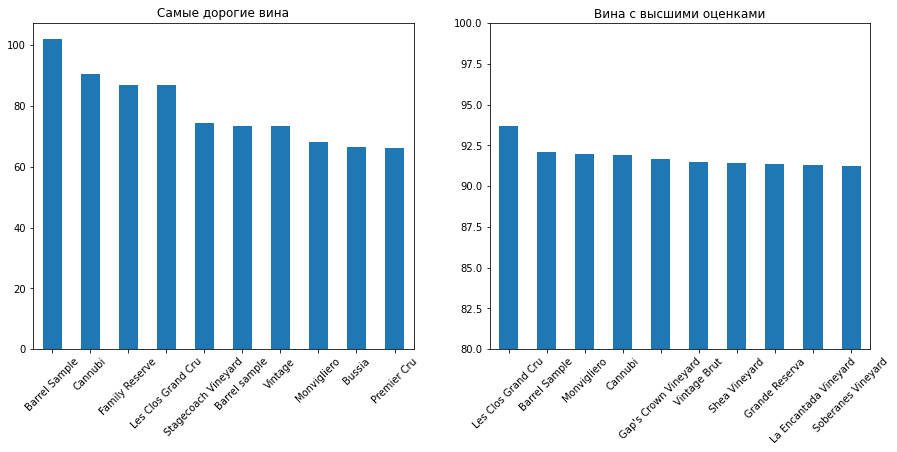

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
top_price_kinds = wine[wine.groupby('designation')['price'].transform('size')>30].groupby('designation')['price'].mean().sort_values(ascending=False).head(10)
top_price_kinds.plot(kind='bar', ax=axes[0], xlabel='', title='Самые дорогие вина', rot=45)
top_points_kinds = wine[wine.groupby('designation')['points'].transform('size')>30].groupby('designation')['points'].mean().sort_values(ascending=False).head(10)
top_points_kinds.plot(kind='bar', ax=axes[1], ylim=(80,100), xlabel='', title='Вина с высшими оценками', rot=45)
plt.show()

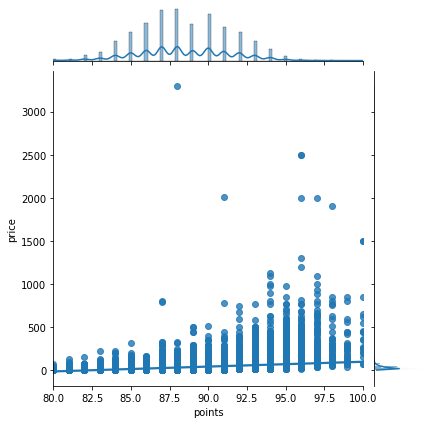

In [23]:
sns.jointplot(x='points', y='price', data=wine, kind='reg')

По графику распределения может показаться, что есть слабая положительная связь между ценой и оценкой, но гистограмма показывает, что это не совсем так. Столбы значений сформированы единичными выбросами. Посмотрим на распределение цен.

In [24]:
wine['price'].describe(percentiles=[.25, .50, .75, .9])

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
90%          65.000000
max        3300.000000
Name: price, dtype: float64

<AxesSubplot:ylabel='Frequency'>

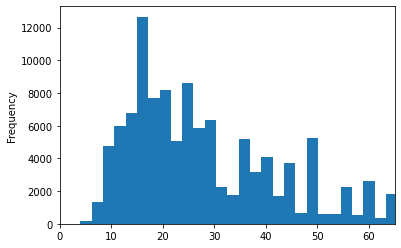

In [25]:
wine['price'].plot(kind='hist', bins=1500, xlim=(0,65))

**90% цен ниже $65**. Проверим корреляцию для них отдельно

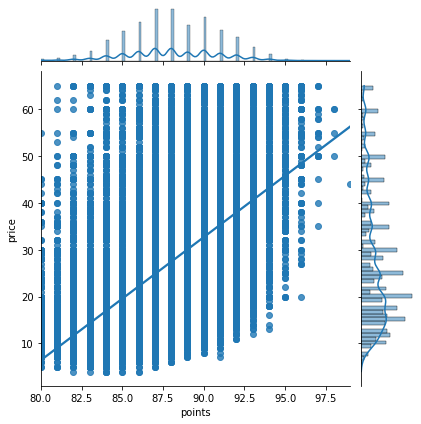

In [26]:
sns.jointplot(x='points', y='price', data=wine[wine['price']<=65], kind='reg')

Линия на графике показывает сильную корреляцию, но значения все равно выглядят сильно разбросанными. Построим линейную модель для описания связи.

In [27]:
price_points_wine = wine[(wine['points'].notnull())&(wine['price']<=65)]
slope, intercept, r, p, std_err = stats.linregress(price_points_wine['price'], price_points_wine['points'])

In [28]:
print(f'''
slope = {slope:.2f}
intercept = {intercept:.2f}
r = {r:.2f}
r-squared = {(r ** 2):.2f}
p = {p:.5f}
std_err = {std_err:.3f}
''')


slope = 0.11
intercept = 85.16
r = 0.53
r-squared = 0.28
p = 0.00000
std_err = 0.001



#### Вывод
При увеличении цены на 1 доллар в среднем оценка повышается на 0.11. Коэффициент детерминации = 0.28, что говорит о том, что оценка всего на 28% обуславливается ценой. Поэтому для большинства вин нельзя сказать, что оценка вина сильно зависит от его цены.

## Итог

**Топ регионов производителей вина**

Среди самых распространенных вин лучшие оценки имеют произведенные в:
* Франция - Champagne (родина игристого), Burgundy, Alsace, Rhône Valley
* Италия - Piedmont, Tuscany, Lombardy
* США - Rhode Island, Oregon, Washington

Среди менее популярных:
* Австрия - Südburgenland, Wachau, Kamptal, Traisental, Eisenberg, Leithaberg
* Португалия - Madeira
* Германия - Mittelrhein
* Чили - Puente Alto, Santa Cruz

Редко встречающиеся:
* Англия - England (видимо, нет разделения на области)
* Греция - Retsina, Markopoulo
* Венгрия - Tokaji
* Индия - Nashik
* Швейцария - Valais, Neuchâtel
* Хорватия - Dingač
* Израиль - Haut-Judeé, Jerusalem Hills

**Топ регионов производителей популярных сортов**
5 самых популярных сортов лучше всего производят:
* Pinot Noir: France Burgundi
* Bordeaux-style Red Blend: South Africa Stellebosch
* Cabernet Sauvignon: Western Australia, Italy Tuscany
* Red Blend: Italy Piedmont
* Chardonnay: France Champagne


**Оценка всего на 28% обуславливается ценой, поэтому для большинства вин нельзя сказать, что оценка вина сильно зависит от его цены.**